# Deep learning

In [1]:
%load_ext autoreload
%autoreload 2

import tasks.data
import tasks.torch_train_eval
import tasks.adaptive_train_eval
import tasks.calibration

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

import random
import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output"

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1

TARGET_VAL_SPLIT = .15
TARGET_TEST_SPLIT = .15
TARGET_DATASET = "webcam"

FINETUNED_MODEL_DIR = os.path.join(OUTPUT_DIR, "classifier")
UNSUPERVISED_MODEL_DIR = os.path.join(OUTPUT_DIR, "unsupervised")
SEMI_SUPERVISED_MODEL_DIR = os.path.join(OUTPUT_DIR, "semi-supervised")

FINETUNE_MODEL = False
TRAIN_UNSUPERVISED_MODEL = True
TRAIN_SEMI_SUPERVISED_MODEL = True

RANDOM_SEED = 42
BATCH_SIZE = 3

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import imageio.v2 as imageio
from torchvision.transforms import v2


def resnet_preprocessor(image: np.ndarray) -> np.ndarray:
    """
    Preprocesses an image for ResNet model.

    :param numpy.ndarray image: The input image.
    :return: Preprocessed image.
    :rtype: numpy.ndarray
    """
    preprocess = torchvision.transforms.Compose(
        [    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
            v2.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

    image = preprocess(image)
    return image


def image_read_func(image_path):
    return imageio.imread(image_path, pilmode='RGB')


In [3]:
import random



def train_val_test_split(
    dataset: tasks.data.ImageDataset, val_ratio: float, test_ratio: float
):
    """
    Splits into pure ImageDataset objects, not Subsets, to allow for dynamic changes in the
    underlying data using the custom class API.
    """
    train_ratio = 1 - val_ratio - test_ratio

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)

    # Split the dataset into train, validation, and test sets
    train_dataset = tasks.data.ImageDataset(
        parser_func=dataset.parser_func,
        preprocessing_func=dataset.preprocessing_func,
        label_encoder=dataset.label_encoder,
    )
    val_dataset = tasks.data.ImageDataset(
        parser_func=dataset.parser_func,
        preprocessing_func=dataset.preprocessing_func,
        label_encoder=dataset.label_encoder,
    )
    test_dataset = tasks.data.ImageDataset(
        parser_func=dataset.parser_func,
        preprocessing_func=dataset.preprocessing_func,
        label_encoder=dataset.label_encoder,
    )

    random.shuffle(dataset.samples)
    for idx, sample in enumerate(dataset.samples):
        if idx < train_size:
            train_dataset.add(sample[0], sample[1])
        elif idx < train_size + val_size:
            val_dataset.add(sample[0], sample[1])
        else:
            test_dataset.add(sample[0], sample[1])

    return train_dataset, val_dataset, test_dataset


source_dataset = tasks.data.ImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset, source_val_dataset, source_test_dataset = train_val_test_split(
    source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [4]:
def create_padded_dataloader(
    dataset: tasks.data.ImageDataset,
    shuffle: bool = True,
    sampler = None
):
    # sampler and shuffle are mutually exclusive
    if sampler is None:
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=shuffle,
            collate_fn=tasks.data.collate_pad,
        )
    else:
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            sampler=sampler,
            collate_fn=tasks.data.collate_pad,
        )


source_train_loader = create_padded_dataloader(source_train_dataset, shuffle=True)
source_val_loader = create_padded_dataloader(source_val_dataset, shuffle=False)
source_test_loader = create_padded_dataloader(source_test_dataset, shuffle=False)

In [5]:
import pickle


def try_load_weights(model, weights_path: str):
    try:
        model.load_state_dict(torch.load(weights_path))
    except Exception as e:
        print("Cannot load proper weights: ", e)
    return model


def try_load_history(history_path):
    try:
        with open(history_path, 'rb') as handle:
            history = pickle.load(handle)
    except:
        print("No history found in path ", history_path)
        history = None

    return history

In [6]:
import torchinfo

def get_default_model():
    return torch.hub.load(
        "pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT"
    ).to(device)

model = get_default_model()
model = try_load_weights(model, os.path.join(FINETUNED_MODEL_DIR, "model.pt"))

torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 300, 300))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [3, 1000]                 --
├─Conv2d: 1-1                            [3, 64, 150, 150]         9,408
├─BatchNorm2d: 1-2                       [3, 64, 150, 150]         128
├─ReLU: 1-3                              [3, 64, 150, 150]         --
├─MaxPool2d: 1-4                         [3, 64, 75, 75]           --
├─Sequential: 1-5                        [3, 64, 75, 75]           --
│    └─BasicBlock: 2-1                   [3, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [3, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-2             [3, 64, 75, 75]           128
│    │    └─ReLU: 3-3                    [3, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [3, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-5             [3, 64, 75, 75]           128
│    │    └─ReLU: 3-6                    [3, 64, 75, 75]           --
│

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)
# disable lr for adam
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.05)
history = try_load_history(os.path.join(FINETUNED_MODEL_DIR, "history.pickle"))


if FINETUNE_MODEL:
    model, history = tasks.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=FINETUNED_MODEL_DIR,
        num_epochs=50,
        patience=10,
        warmup_period=25,
        previous_history=history
    )

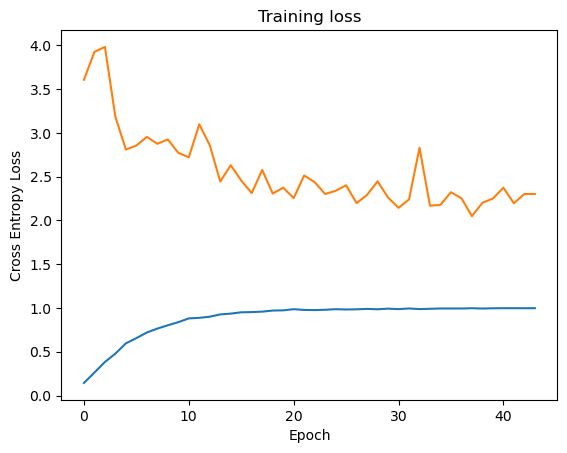

In [8]:
plt.plot(np.array(range(len(history["train_loss"]))), history["train_loss"])
plt.plot(np.array(range(len(history["val_loss"]))), history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training loss")
plt.show()

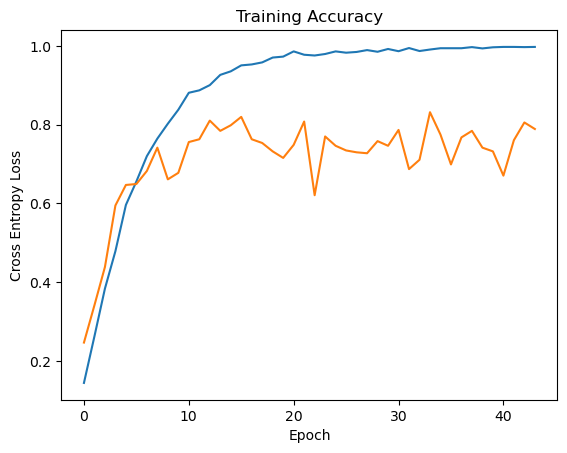

In [9]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

In [10]:
# save logits for later calibration
source_actual, source_predicted = tasks.torch_train_eval.test(
    model, source_test_loader, device
)
class_names = source_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        source_actual,
        source_predicted,
        zero_division=0,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

  0%|          | 0/95 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.78      1.00      0.88         7
            bike       1.00      1.00      1.00         5
     bike_helmet       1.00      1.00      1.00         7
        bookcase       0.78      1.00      0.88         7
          bottle       0.40      0.50      0.44         4
      calculator       0.80      1.00      0.89         8
      desk_chair       1.00      1.00      1.00        10
       desk_lamp       0.88      0.88      0.88         8
desktop_computer       0.86      0.46      0.60        13
    file_cabinet       1.00      0.50      0.67        10
      headphones       1.00      0.60      0.75         5
        keyboard       0.87      0.76      0.81        17
 laptop_computer       1.00      0.92      0.96        13
     letter_tray       1.00      0.50      0.67         6
    mobile_phone       1.00      0.78      0.88         9
         monitor       1.00      0.89      0.94         9
           mo

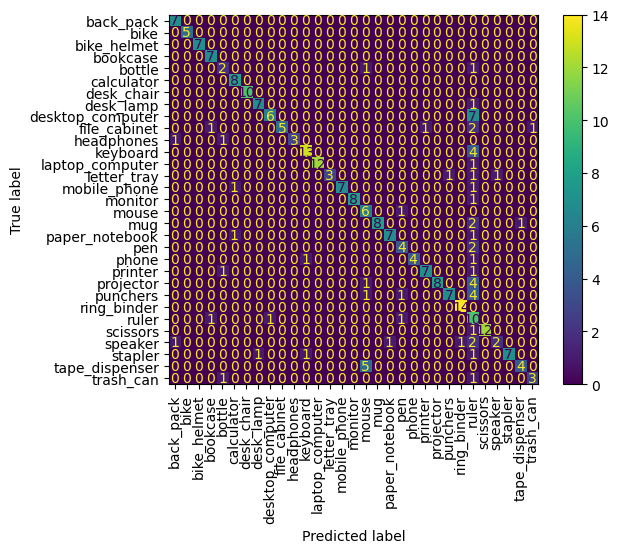

In [11]:
source_cf_matrix = sklearn.metrics.confusion_matrix(source_actual, source_predicted)
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=source_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

In [12]:
target_dataset = tasks.data.ImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
    label_encoder=source_dataset.label_encoder # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset, target_val_dataset, target_test_dataset = train_val_test_split(
    target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
)

target_train_loader = create_padded_dataloader(target_train_dataset, shuffle=True)
target_test_loader = create_padded_dataloader(target_test_dataset, shuffle=False)

  0%|          | 0/31 [00:00<?, ?it/s]

In [13]:
target_actual, target_predicted = tasks.torch_train_eval.test(model, target_test_loader, device)
class_names = target_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        target_actual,
        target_predicted,
        zero_division=0,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

  0%|          | 0/40 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.67      0.40      0.50         5
            bike       1.00      0.50      0.67         2
     bike_helmet       0.75      0.75      0.75         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       1.00      0.50      0.67         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       1.00      0.67      0.80         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

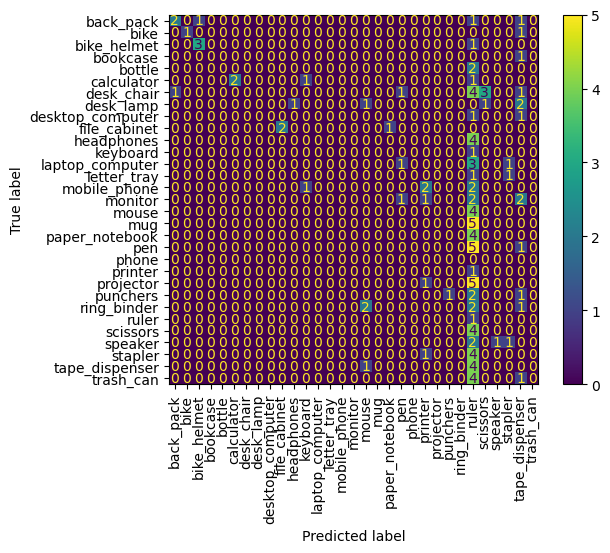

In [14]:
target_cf_matrix = sklearn.metrics.confusion_matrix(target_actual, target_predicted, labels=np.arange(0, len(class_names), 1))
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=target_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

## Unsupervised Domain Adaptation

https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/pseudo-labeling-to-deal-with-small-datasets-what-why-how-fd6f903213af

https://stats.stackexchange.com/questions/364584/why-does-using-pseudo-labeling-non-trivially-affect-the-results

https://www.sciencedirect.com/science/article/abs/pii/S1077314222001102

In [15]:
unlabeled_dataset = tasks.data.UnlabeledImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)
unlabeled_dataset.load_from_image_dataset(target_train_dataset)

source_history = try_load_history(os.path.join(UNSUPERVISED_MODEL_DIR, "source_history.pickle"))
target_history = try_load_history(os.path.join(UNSUPERVISED_MODEL_DIR, "target_history.pickle"))

No history found in path  output/unsupervised/source_history.pickle
No history found in path  output/unsupervised/target_history.pickle


In [17]:
if TRAIN_UNSUPERVISED_MODEL:
    model, source_history, target_history = (
        tasks.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=source_train_dataset,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: create_padded_dataloader(
                dataset,
                sampler=sampler,
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset,
            target_val_dataset=target_val_dataset,
            output_dir=UNSUPERVISED_MODEL_DIR,
            num_epochs=20,
            previous_source_history=source_history,
            previous_target_history=target_history,
        )
    )

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Selected 19/556 remaining images to be included in next epoch
Epoch 0/19
----------


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

source dataset Train Loss: 1.4746 Train Acc: 0.9474
Source dataset Val Loss: 2.3649 Val Acc: 0.6801
Target dataset Val Loss: 3.8920 Val Acc: 0.1597


  0%|          | 0/537 [00:00<?, ?it/s]

Selected 33/537 remaining images to be included in next epoch
Epoch 1/19
----------


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

source dataset Train Loss: 1.5390 Train Acc: 0.8846
Source dataset Val Loss: 2.2872 Val Acc: 0.7986
Target dataset Val Loss: 3.9584 Val Acc: 0.1765


  0%|          | 0/504 [00:00<?, ?it/s]

Selected 2/504 remaining images to be included in next epoch
Epoch 2/19
----------


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

source dataset Train Loss: 1.2147 Train Acc: 0.9630
Source dataset Val Loss: 2.2732 Val Acc: 0.7678
Target dataset Val Loss: 3.8465 Val Acc: 0.2185


  0%|          | 0/502 [00:00<?, ?it/s]

Selected 0/502 remaining images to be included in next epoch
Epoch 3/19
----------


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

source dataset Train Loss: 1.1618 Train Acc: 0.9815
Source dataset Val Loss: 2.3489 Val Acc: 0.7275
Target dataset Val Loss: 3.6721 Val Acc: 0.2185


  0%|          | 0/502 [00:00<?, ?it/s]

Selected 2/502 remaining images to be included in next epoch
Epoch 4/19
----------


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

source dataset Train Loss: 1.1617 Train Acc: 0.9821
Source dataset Val Loss: 2.2079 Val Acc: 0.7441
Target dataset Val Loss: 3.8134 Val Acc: 0.1849


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
plt.plot(np.array(range(len(target_history["train_acc"]))), target_history["train_acc"])
plt.plot(np.array(range(len(target_history["val_acc"]))), target_history["val_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training loss")
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [19]:
target_actual, target_predicted = tasks.torch_train_eval.test(model, target_test_loader, device)
class_names = target_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        target_actual,
        target_predicted,
        zero_division=0,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

  0%|          | 0/40 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.00      0.00      0.00         5
            bike       0.00      0.00      0.00         2
     bike_helmet       0.33      0.75      0.46         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       0.09      0.75      0.17         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.50      0.33      0.40         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

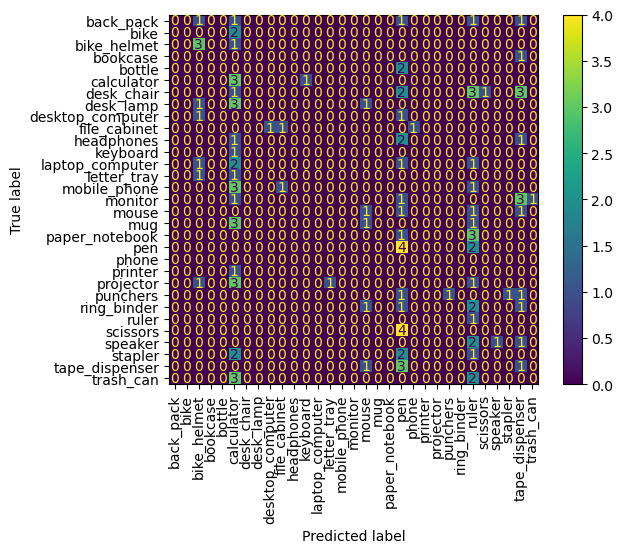

In [20]:
target_cf_matrix = sklearn.metrics.confusion_matrix(target_actual, target_predicted, labels=np.arange(0, len(class_names), 1))
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=target_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

## Semi-supervised domain adaptation

In [21]:
from sklearn.model_selection import train_test_split


def stratified_split(
    image_dataset: tasks.data.ImageDataset, test_size=0.2, random_state=None
) -> tuple[tasks.data.ImageDataset, tasks.data.ImageDataset]:
    data = image_dataset.samples
    # Extract class labels
    labels = [class_id for _, class_id in data]

    # Split the data while preserving the class distribution
    _, test_indices = train_test_split(
        range(len(data)),
        test_size=test_size,
        stratify=labels,
        random_state=random_state,
    )

    # Split the data based on the indices
    test_data = [data[i] for i in test_indices]
    train_data = [data[i] for i in range(len(data)) if i not in test_indices]

    train_dataset = tasks.data.ImageDataset(
        parser_func=image_dataset.parser_func,
        preprocessing_func=image_dataset.preprocessing_func,
    )
    test_dataset = tasks.data.ImageDataset(
        parser_func=image_dataset.parser_func,
        preprocessing_func=image_dataset.preprocessing_func,
    )

    for train_sample in train_data:
        train_dataset.add(train_sample[0], train_sample[1])

    for test_sample in test_data:
        test_dataset.add(test_sample[0], test_sample[1])


    return train_dataset, test_dataset

In [29]:
to_be_unlabeled_dataset, labeled_dataset = stratified_split(
    target_train_dataset, test_size=0.2
)

len(unlabeled_dataset), len(labeled_dataset), len(target_train_dataset)

(444, 112, 556)

In [30]:
unlabeled_dataset = tasks.data.UnlabeledImageDataset(
    parser_func=labeled_dataset.parser_func,
    preprocessing_func=labeled_dataset.preprocessing_func,
)
unlabeled_dataset.load_from_image_dataset(to_be_unlabeled_dataset)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset.add(sample_img, sample_label)

len(labeled_dataset), len(source_train_dataset)

(2224, 2112)

In [27]:
model = get_default_model()

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


In [31]:
if TRAIN_UNSUPERVISED_MODEL:
    print("Starting fine-tuning on mixed dataset...")
    model, history = tasks.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        create_padded_dataloader(labeled_dataset, shuffle=True),
        source_val_loader,
        output_dir=SEMI_SUPERVISED_MODEL_DIR,
        num_epochs=30,
        patience=5,
        warmup_period=1,
        previous_history=history
    )
    
    print("Starting pseudolabeling task...")
    model, source_history, target_history = (
        tasks.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: create_padded_dataloader(
                dataset,
                sampler=sampler,
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset,
            target_val_dataset=target_val_dataset,
            output_dir=UNSUPERVISED_MODEL_DIR,
            num_epochs=20,
            previous_source_history=source_history,
            previous_target_history=target_history,
        )
    )

Starting fine-tuning on mixed dataset.
Epoch 0/29
----------


  0%|          | 0/742 [00:00<?, ?it/s]

## Dustbin